In [1]:
import numpy as np
import pandas as pd
import sys
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
sys.path.append('..\\custom_libraries')

# Custom library to analyze NC rate of deterioration
import rate_analysis

df = pd.read_csv('../../spreadsheet_data/i16WB_tag_replaced.csv')
nc_distance_from_damaged_by_year = {}



In [2]:
################################################################################
# General Purpose Functions for Plotting
################################################################################

def exponential_decay(x, a, b):
        return a * np.exp(-b * x)

def plot_exponential_decay_best_fit(x_data: np.array, y_data: np.array, x_label: str, y_label: str, title: str):
        """Plots exponential best fit curve for given data. 

        Args:
            x_data (np.array): numpy array of data for x-axis
            y_data (np.array): numpy array of data for y-axis
            x_label (str): x-axis label
            y_label (str): y-axis label
            title (str): title of the plot
        """
        params, covariance = curve_fit(exponential_decay, x_data, y_data)
        a, b = params
        x = np.linspace(1, 20, 100)
        y = a * np.exp(-b * x)
        str_a = f'{a:.2f}'
        str_b = f'{b:.2f}'
        y_pred = exponential_decay(x_data, *params)
        r2 = r2_score(y_data, y_pred)
        fig, ax = plt.subplots()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.scatter(x_data, y_data)
        plt.plot(x, y, label=f'Fitted Curve: y = ${str_a}e^{{-{str_b}x}}$\n $R^2 = {r2:.2f}$', color='red')
        plt.legend()
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.show()


In [3]:
# Analyze the deterioration rate vs. distance for the entire 4 year period
df_whole_period = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 4)
fig = px.scatter(df_whole_period, x='distance', y='deterioration_rate', title='Rate of Deterioration vs Distance to Nearest Damaged Slab for the Whole Period')
#fig.show()

In [4]:
# Explore the relationship between distance and deterioration rate for 1 year periods (4 x 1 year)
df_whole_period = df_whole_period[df_whole_period['distance'] <= 20]
fig = px.scatter(df_whole_period, x='distance', y='deterioration_rate')
#fig.show()

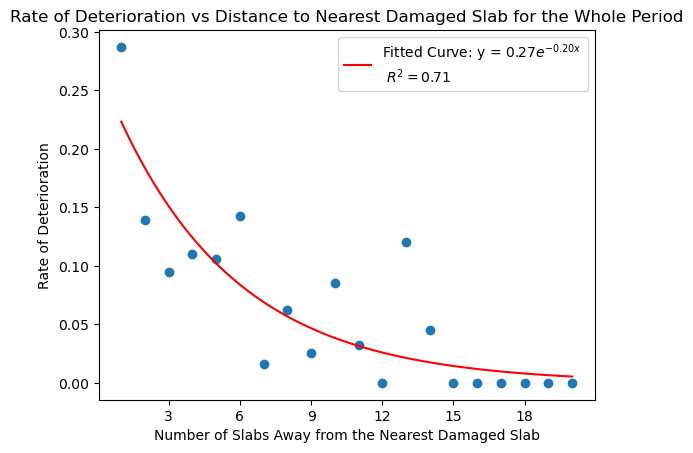

In [5]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (4 year transition period)
# Definition of Damaged: T1, L1, T2, L2, CC, SS, R
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

x_data = df_whole_period['distance'].to_numpy().astype(np.float32)
y_data = df_whole_period['deterioration_rate'].to_numpy().astype(np.float32)

plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'Rate of Deterioration vs Distance to Nearest Damaged Slab for the Whole Period')


In [6]:

df_by_year = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1)
fig = px.scatter(df_by_year, x='distance', y='deterioration_rate', color='period', title='Rate of Deterioration vs Distance to Nearest Damaged Slab by Year')
#fig.show()

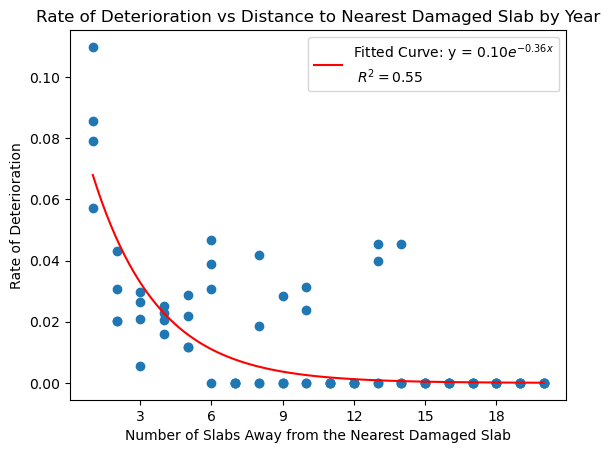

In [7]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (four transition periods, each 1 year long)
# Definition of Damaged: T1, L1, T2, L2, CC, SS, R
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
df_by_year = df_by_year[df_by_year['distance'] <= 20]
x_data = df_by_year['distance'].to_numpy().astype(np.float32)
y_data = df_by_year['deterioration_rate'].to_numpy().astype(np.float32)

plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'Rate of Deterioration vs Distance to Nearest Damaged Slab by Year')



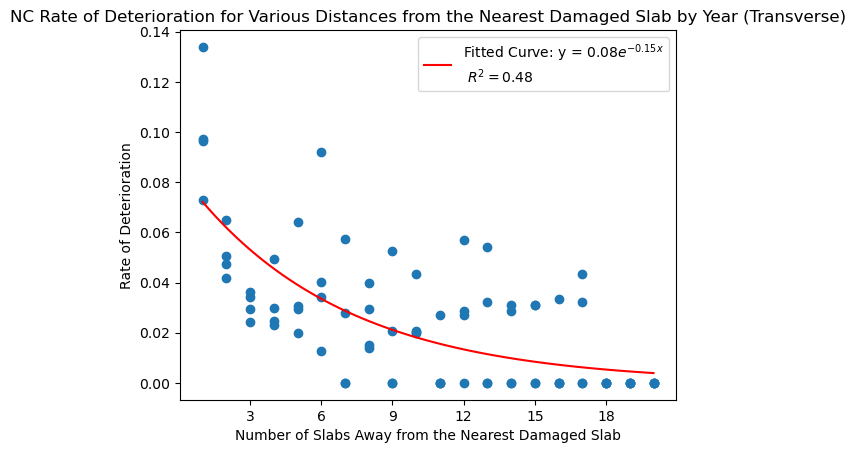

In [8]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (four transition periods, each 1 year long)
# Definition of Damaged: T1, T2, SS (transverse cracked slabs)
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

df_transverse = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1, {'SS', 'T2', 'T1'})
df_transverse = df_transverse[df_transverse['distance'] <= 20]
x_data = df_transverse['distance'].to_numpy().astype(np.float32)
y_data = df_transverse['deterioration_rate'].to_numpy().astype(np.float32)
plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'NC Rate of Deterioration for Various Distances from the Nearest Damaged Slab by Year (Transverse)')

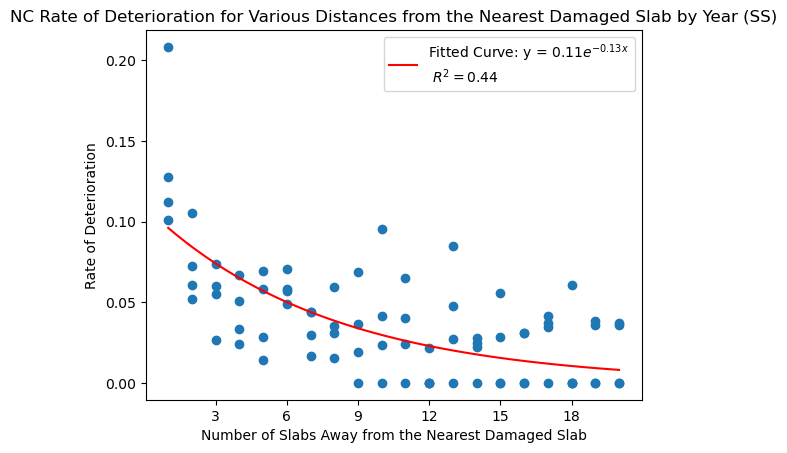

In [9]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (four transition periods, each 1 year long)
# Definition of Damaged: SS 
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

df_SS = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1, {'SS'})
df_SS = df_SS[df_SS['distance'] <= 20]
x_data = df_SS['distance'].to_numpy().astype(np.float32)
y_data = df_SS['deterioration_rate'].to_numpy().astype(np.float32)
plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'NC Rate of Deterioration for Various Distances from the Nearest Damaged Slab by Year (SS)')

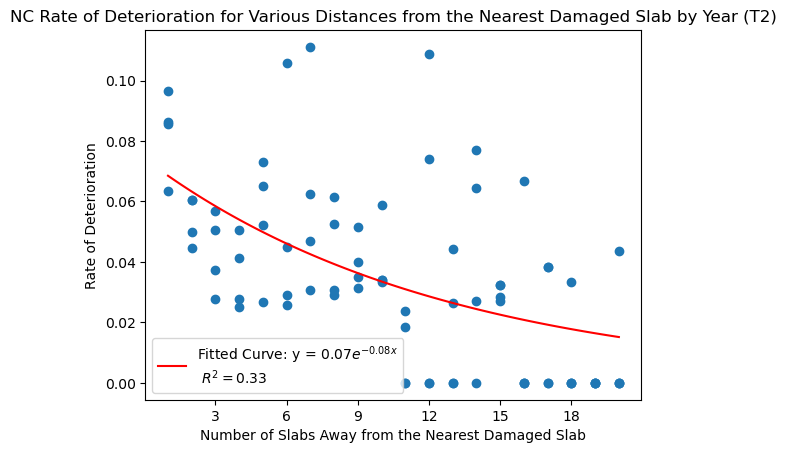

In [10]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (four transition periods, each 1 year long)
# Definition of Damaged: T2
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

df_T2 = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1, {'T2'})
df_T2 = df_T2[df_T2['distance'] <= 20]
x_data = df_T2['distance'].to_numpy().astype(np.float32)
y_data = df_T2['deterioration_rate'].to_numpy().astype(np.float32)
plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'NC Rate of Deterioration for Various Distances from the Nearest Damaged Slab by Year (T2)')

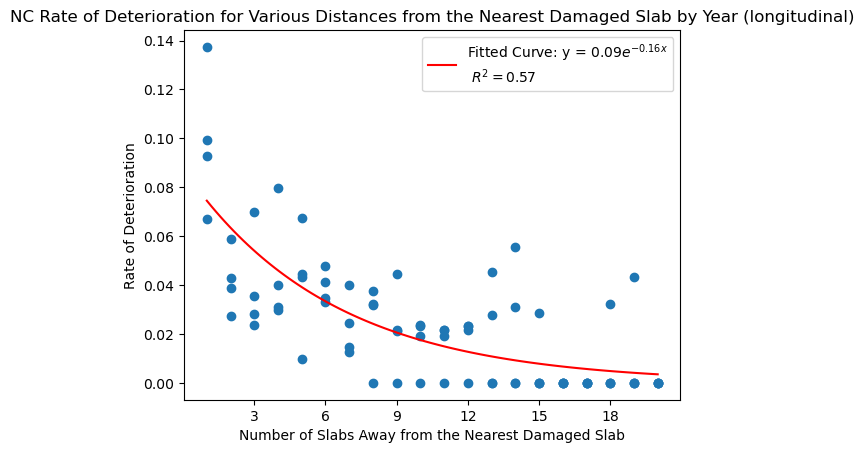

In [11]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Time Interval: 2014-2018 (four transition periods, each 1 year long)
# Definition of Damaged: L1, L2, SS (longitudinal cracked slabs)
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

df_long = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1, {'L1', 'L2', 'SS'})
df_long = df_long[df_long['distance'] <= 20]
x_data = df_long['distance'].to_numpy().astype(np.float32)
y_data = df_long['deterioration_rate'].to_numpy().astype(np.float32)
plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'NC Rate of Deterioration for Various Distances from the Nearest Damaged Slab by Year (longitudinal)')

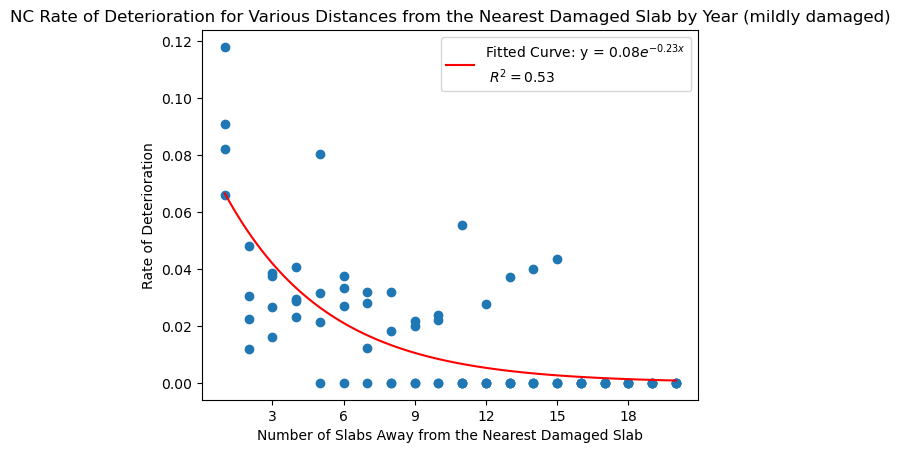

In [12]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Generate different plots for different combinations of damaged slab types

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

df_long = rate_analysis.construct_nc_deterioration_rate_table(df, 2014, 2018, 1, {'T2', 'L2', 'CC', 'SS', 'R'})
df_long = df_long[df_long['distance'] <= 20]
x_data = df_long['distance'].to_numpy().astype(np.float32)
y_data = df_long['deterioration_rate'].to_numpy().astype(np.float32)
plot_exponential_decay_best_fit(x_data, y_data, 'Number of Slabs Away from the Nearest Damaged Slab', 'Rate of Deterioration', 'NC Rate of Deterioration for Various Distances from the Nearest Damaged Slab by Year (mildly damaged)')